# Support Vector Machines

# Outline

1. [Support Vector Machines: motivation](#svm)
2. [Maximum margin hyperplane](#hyper)
3. [SVM Implementation](#impl)
4. [Kernel trick](#kernel)
5. [Dual SVM problem](#dual)
6. [Support vector regression](#svr)

### Setup

In [1]:
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import sklearn.datasets as datasets
import sklearn.model_selection as model_selection
import sklearn.metrics.pairwise as pairwise
from sklearn.metrics.pairwise import pairwise_kernels

<a id="svm"></a>

## Support vector machines: motivation

Types of classification techniques:
- generative methods: the model learns the distribution of the underlying class and assigns new points with a probability; examples: **kNN**, naive Bayes
- discriminative methods: try to find a boundary (a curve or hyperplane) dividing the training set and use it to make predictions on new data points; examples: **logistic regression**

From [Wikipedia](#https://en.wikipedia.org/wiki/Support-vector_machine): Support-Vector Machines (SVMs) are supervised learning models with associated learning algorithms that analyze data for classification and regression analysis.

Cortes, Corinna; Vladimir Vapnik (1995)."Support-Vector Networks". Machine Learning. 20 (3): 273–297. doi:10.1007/BF00994018.

The SVM algorithm was initially developed by Vladimir Vapnik in 1963 while working on the _Generalized Portrait Algorithm_ (GPA). He then developed the __VC theory__ with Alexey Chervonenkis, which attempts to explain the learning process from a statistical point of view.  Both scientist developed the SVM theory.

SVMs are a very performant off-the-shelf supervised machine learning algorithm. _off-the-shelf_ means that running a SVM on a problem will often give robust and accurate results without many tweaks.

<a id="hyper"></a>

## The maximum margin hyperplane

Suppose we have a __linearly__ separable 2D data set:

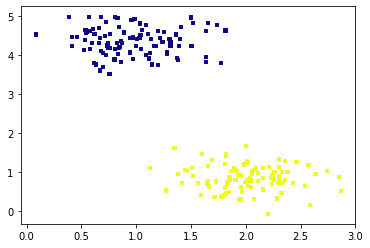

In [2]:
X, y = datasets.make_blobs(n_samples=200, centers=2,
                  random_state=0, cluster_std=.35)
plt.scatter(X[:, 0], X[:, 1], marker='s', c=y, s=10, cmap='plasma');

This data is easy to handle with a linear classifier

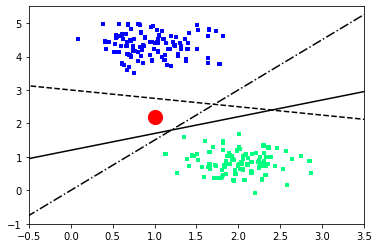

In [3]:
plt.scatter(X[:, 0], X[:, 1], marker='s', c=y, s=10, cmap='winter')
outlier = (1,2.2)
plt.scatter(outlier[0], outlier[1], marker='o', color='red',s=200)
plt.xlim(-0.5,3.5)
plt.ylim(-1,5.5)
classifier = np.linspace(-1, 4.)
M = (0.5, 1.5, -0.25)
Q = (1.2, 0.,3.)
S = iter(('-','-.','--'))

for m,q in zip(M,Q):
    plt.plot(classifier, m*classifier+q, c='k', ls=next(S))

Binary classification can thus be viewed as the task of separating classes in feature space (defining a *decision boundary*):
- on a line: $\mathbf{w}^T\mathbf{x} + b =0$
- above a line (class 1): $\mathbf{w}^T\mathbf{x} + b > 0$
- below a line (class 0): $\mathbf{w}^T\mathbf{x} + b < 0$  

In general the output will be:
$$ f(\mathbf{x}) = sign(\mathbf{w}^T\mathbf{x}+b) $$  

with $i={0,\ldots,n}$ features and $j={0,\ldots,m}$ points: $\mathbf{w}^T\in \mathbb{R}^{1\times n}$ and 
$\mathbf{x}\in \mathbb{R}^{n\times m}$

Depending on how the line is drawn the red outlier is assigned to either class. But the lines are not all the same; they leave more space for points from class or another. 

(0.5, 1.2, '-', 0.2)
(1.5, 0.0, '-.', 0.35)
(-0.25, 3.0, '--', 0.6)


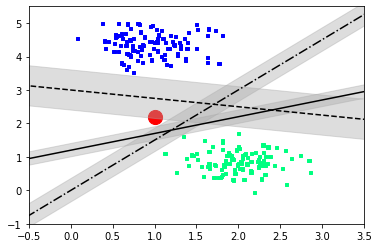

In [4]:
plt.scatter(X[:, 0], X[:, 1], marker='s', c=y, s=10, cmap='winter')
outlier = (1,2.2)
plt.scatter(outlier[0], outlier[1], marker='o', color='red',s=200)
plt.xlim(-0.5,3.5)
plt.ylim(-1,5.5)
M = (0.5, 1.5, -0.25)
Q = (1.2, 0.,3.)
classifier = np.linspace(-1, 4.)
elements = ((0.5, 1.2, "-", 0.2),(1.5, 0., "-.", 0.35),(-0.25, 3., "--", 0.6))
for e in elements:
    print(e)
    yy = e[0]*classifier+e[1]
    plt.plot(classifier, yy , c='k', ls=e[2])
    plt.fill_between(classifier, yy-e[3], yy + e[3], edgecolor='none',color='#AAAAAA', alpha=0.4)

Each line has a different width or __margin__ that separates it from the nearest point in the data. We must somehow determine the separator with the greatest margin because it will yield the minimum of false classifications. We may define also the two hyperplanes lying exactly on the border of one class (__positive__ and __negative__ hyperplane).

We define these hyperplanes as:
- $\mathbf{w}\mathbf{x} -b = 1$; all points above this line are class 1
- $\mathbf{w}\mathbf{x} -b = - 1$; all points below this line are class -1
- $\mathbf{w}\mathbf{x} -b = 0 $; mid way between the two classes

where $\mathbf{w}$ is normal vector to the plane: ($\mathbf{n}\cdot(\mathbf{r}-\mathbf{r}_0)=0$) with $n\rightarrow w$.

<div>
<img src="boundary.png" width="400"/>
</div>

To define the margin we need to calculate the distance $\rho$ between the two extreme hyperplanes. By definition $\rho\frac{\mathbf{w}}{\mid\mid \mathbf{w}\mid\mid}$ is a vector between the two hyperplanes.  
Let $\mathbf{x}_1$ be a point on the positive hyperplane: $\mathbf{w}\mathbf{x}_1-b=1$. By definition
$$ \mathbf{x}_{-1} = \mathbf{x}_1-\rho\frac{\mathbf{w}}{\mid\mid \mathbf{w}\mid\mid} = -1$$ 
since $\mathbf{x}_{-1}$ must lie on the other hyperplane. Thus:
$$ \mathbf{w}(\mathbf{x}_1-\rho\frac{\mathbf{w}}{\mid\mid \mathbf{w}\mid\mid})-b = -1$$

Expanding (with $ \mathbf{w}\mathbf{x}_1-b=1$ by definition):
$$ \mathbf{w}\mathbf{x}_1-\rho\frac{\mid\mid \mathbf{w}\mid\mid^2}{\mid\mid \mathbf{w}\mid\mid}-b = -1 $$
$$ \mathbf{w}\mathbf{x}_1-\rho \mid\mid \mathbf{w}\mid\mid-b = -1 $$
$$ \mathbf{w}\mathbf{x}_1-b = -1 +\rho \mid\mid \mathbf{w}\mid\mid$$
$$ \frac{2}{\mid\mid\mathbf{w}\mid\mid} = \rho $$

More simply, if $\mathbf{x}_1$ and $\mathbf{x}_{-1}$ are points lying on the two hyperplanes we have:
$$\mathbf{w}\mathbf{x}_1-b=1$$
$$\mathbf{w}\mathbf{x}_{-1}-b=-1$$
Subtracting the second definition from the first:
$$\mathbf{w}\mathbf{x}_1-\mathbf{w}\mathbf{x}_{-1} = 2 $$
and dividing by $\mid\mid \mathbf{w}\mid\mid$:
$$x_1 - x_{-1} = \rho = \frac{2}{\mid\mid\mathbf{w}\mid\mid} $$

To constrain points to lie on the "correct side" we write:
$$y_j=1 \rightarrow \mathbf{w}\mathbf{x}_j -b\geq 1$$  
$$y_j=-1 \rightarrow \mathbf{w}\mathbf{x}_j -b\leq -1$$  
or simply
$$y_j\cdot(\mathbf{w}\mathbf{x}_j-b)\geq 1\ \forall\ j$$

Points closest to the hyperplane are __support vectors__ and determine the _maximum margin_.
We must determine the $w $ that minimize $\mid\mid w\mid\mid$ under the constraint above.

What if the points are not linearly separable? We may define a cost function to be minimized and try to strike a balance.

### Cost function

Having defined goal and constraints we can derive the cost function $J$:
$$J(\mathbf{w},b) = \frac{1}{m}\sum_{i=1}^m max[0,\ 1-y_i(\mathbf{w}\cdot \mathbf{x}_i)-b)] +\frac{\lambda}{2}\mid\mid w\mid\mid^2$$
where the first term is called __hinge loss__.

the second term maximizes the margin and the second one applies the constraints.

We use once again _gradient descent_ for local minimization ($J$ is convex). The presence of the max function generates two cases:
$$
\begin{cases}
  J_j = \frac{\lambda}{2}\mid\mid w\mid\mid^2 & \text{if } y_j(\mathbf{w x}_j-b)\geq 1\\    
  J_j = \frac{\lambda}{2}\mid\mid w\mid\mid^2 +1-y_j(\mathbf{w x}_j-b) & \text{otherwise}
\end{cases}
$$

Hence we have the following partial derivatives:

__case__ 1:
$$
\begin{align}
    \frac{\partial J_j}{\partial w_i} = & \lambda w_i \\
    \frac{\partial J_j}{\partial b} = & 0 \\
\end{align} 
$$

__case__ 2:
$$
\begin{align}
    \frac{\partial J_j}{\partial w_i} = & \lambda w_k -y_j \mathbf{x}_j\\
    \frac{\partial J_j}{\partial b} = & -y_j \\
\end{align} 
$$

we have now set up the main formal aspects. Let's try to implement it

<a id="impl"></a>

### SVM implementation

What we want to do is:
1. Get initial values for $\mathbf{w}$ and $b$
2. Map points in the two classes 1,-1
3. Minimize J with gradient descent
4. Test predictions.

In [5]:
class SVM:
    """
    helper function for SVM classifier
    """
    def __init__(self, alpha=5e-4, reg=0.5, verbose=10):
        #lambda is a reserved kwd
        """
        - alpha: GD learning rate
        - lambda: regularization parameter
        """
        self.alpha = alpha
        self.reg   = reg
        self.verbose = verbose

    def _init_data(self, X):
        """
        initializes w and b to the correct shape
        """
        n_features = X.shape[1]
        self.ninv = 1./n_features
        self.w = np.zeros(n_features)
        self.b = 0
                
    def predict(self, X):
        """
        Predict the class
        """
        prediction = np.sign(np.dot(X, self.w) + self.b)
        return prediction  
    
    def _cost(self):
        pass
    
    def fit(self):
        """
        Train SVM classifier.
        - X mxn are the features
        - y {-1,1}xn are the classes
        """
        if self.verbose > 0:
            nprint = niter // self.verbose
        self._init_data(X)
        # run GD
        for n in range(niter):
            pass
        if (n+1) % nprint == 0:
            J = self._cost(X, y)
            print("------ Step {} -> Cost = {} -----".format(n, J))

### Exercise 1

a. Implement the Gradient descent method.  
b. How to check for convergence?  
c. How to check for correctness?

Note: there no private and public methods in Python ma those which should be private are often written as:  
        `_some_method  `  
while those that expose functionalities as:  
        `some_method  `

<div>
<img src="gears.png" width="400"/>
</div>

### Solution 1

a+b

In [6]:
class SVM:
    """
    helper function for VMS classifier
    """
    def __init__(self, alpha=1e-3, reg=1e-2, verbose=10):
        #lambda is a reserved kwd
        """
        - alpha: GD learning rate
        - lambda: regularization parameter
        """
        self.alpha = alpha
        self.reg   = reg
        self.verbose = verbose

    def _init_data(self, X):
        """
        initializes w and b to the correct shape
        """
        n_features = X.shape[1]
        self.ninv = 1./n_features
        self.w = np.zeros(n_features)
        self.b = 0
        
    def cost_function(self, X, y):
        sum_terms = 1-y*(np.dot(X,self.w)-self.b)
        sum_terms = np.where(sum_terms<0,0,sum_terms)
        J = self.reg*np.sum(self.w**2)/2. +np.sum(sum_terms)/y.shape[0]
        return J         

    def fit(self, X, y, niter=500):
        """
        Train SVM classifier.
        - X mxn are the features
        - y {-1,1}xn are the classes
        """
        if self.verbose > 0:
            nprint = niter // self.verbose
        self._init_data(X)
        # run GD
        for n in range(niter):
            for index, x_i in enumerate(X):
                case = y[index] * (np.dot(x_i, self.w) - self.b) >= 1
                if case:
                    self.w -= self.alpha*(self.reg * self.w)
                else:
                    self.w -= self.alpha*(self.reg * self.w - np.dot(x_i, y[index])
                    )
                    self.b -= self.alpha * y[index]
            if (n+1) % nprint == 0:
                J = self.cost_function(X, y)
                print("------ Step {} -> Cost = {} -----".format(n, J))
                
    def predict(self, X):
        """
        Predict the class of points in X
        """
        prediction = np.sign(np.dot(X, self.w) - self.b)
        return prediction

c. Just check the number of correct predictions ...

In [7]:
def accuracy(y_true, y_pred):
    """
    print the ratio of correct predictions
    """
    accuracy = np.sum(y_true==y_pred) / len(y_true)
    return accuracy

Remap classes in the correct range!

In [8]:
y = np.where(y <= 0, -1, 1)

Test the SVM. We create a _test_ and _train_ set with SciKit Learn.

In [9]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.1, shuffle=True, random_state=1)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(180, 2) (20, 2)
(180,) (20,)


In [10]:
mySVM = SVM()
mySVM.fit(X_train, y_train, niter=2000)
predictions = mySVM.predict(X_test)
print(accuracy(y_test, predictions))

------ Step 199 -> Cost = 0.011432175853096874 -----
------ Step 399 -> Cost = 0.0103367681250282 -----
------ Step 599 -> Cost = 0.009380446058166144 -----
------ Step 799 -> Cost = 0.008533074953960683 -----
------ Step 999 -> Cost = 0.007765643558682534 -----
------ Step 1199 -> Cost = 0.007071279515443061 -----
------ Step 1399 -> Cost = 0.0065377417379158375 -----
------ Step 1599 -> Cost = 0.006217587931846694 -----
------ Step 1799 -> Cost = 0.0059463657836514895 -----
------ Step 1999 -> Cost = 0.005702522609349589 -----
1.0


Let's have a look

In [11]:
mySVM.w, mySVM.b

(array([ 0.33511407, -0.88137076]), -1.8209999999999102)

How to draw the boundaries?

In [12]:
def hyper_y(w,b,x,off=0):
    """
    Return the y coordinate of a point on the
    decision boundary or on the positive (off=1)
    or negative (off=-1) line
    """
    # in 2D wx-b is just ax+by+c=0 for a straight line
    return (-w[0] * x + b + off) / w[1]

In [13]:
def draw_lines(model, X):
    """
    Given 2D SVM classifier and a data set
    draw the decision boundary and the positive
    and negative lines
    """
    xmin = np.min(X[:,0])
    xmax = np.max(X[:,0])
    dec_min = hyper_y(model.w, model.b, xmin)
    dec_max = hyper_y(model.w, model.b, xmax)
    pp_min  = hyper_y(model.w, model.b, xmin, off=1)
    pp_max  = hyper_y(model.w, model.b, xmax, off=1)
    pn_min  = hyper_y(model.w, model.b, xmin, off=-1)
    pn_max  = hyper_y(model.w, model.b, xmax, off=-1)
    return ((dec_min,dec_max),(pp_min,pp_max),(pn_min,pn_max))

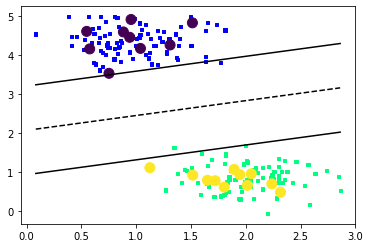

In [14]:
plt.scatter(X_train[:, 0], X_train[:, 1], marker='s', c=y_train, s=10, cmap='winter')
plt.scatter(X_test[:, 0], X_test[:, 1], marker='o', c=y_test, s=100, cmap='viridis')
lines = draw_lines(mySVM, X_train)
for s, S in enumerate(('--','-','-')):
    plt.plot((np.min(X_train[:,0]),np.max(X_train[:,0])),lines[s],ls=S,c='k')

What happens if the data is more noisy?

In [16]:
X, y = datasets.make_blobs(n_samples=200, centers=2, random_state=0, cluster_std=1)
y = np.where(y <= 0, -1, 1)

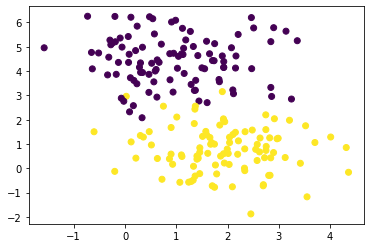

In [17]:
plt.scatter(X[:,0],X[:,1], c=y, cmap="viridis")

In [18]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.1, shuffle=True, random_state=1)
mySVM = SVM(verbose=10)
mySVM.fit(X_train, y_train, niter=5000)
predictions = mySVM.predict(X_test)
print(accuracy(y_test, predictions))

------ Step 499 -> Cost = 0.09239402369305928 -----
------ Step 999 -> Cost = 0.08648439503480095 -----
------ Step 1499 -> Cost = 0.08560844838347087 -----
------ Step 1999 -> Cost = 0.08564411876871401 -----
------ Step 2499 -> Cost = 0.08562912801898116 -----
------ Step 2999 -> Cost = 0.08562883226113539 -----
------ Step 3499 -> Cost = 0.08562246096465109 -----
------ Step 3999 -> Cost = 0.08560970226968144 -----
------ Step 4499 -> Cost = 0.08561483717709059 -----
------ Step 4999 -> Cost = 0.08563891786696147 -----
0.95


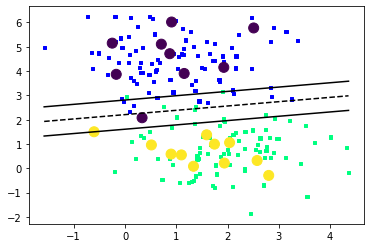

In [19]:
plt.scatter(X_train[:, 0], X_train[:, 1], marker='s', c=y_train, s=10, cmap='winter')
plt.scatter(X_test[:, 0], X_test[:, 1], marker='o', c=y_test, s=100, cmap='viridis')
lines = draw_lines(mySVM, X_train)
for s, S in enumerate(('--','-','-')):
    plt.plot((np.min(X_train[:,0]),np.max(X_train[:,0])),lines[s],ls=S,c='k')

<a id="kernel"></a>

## Kernel trick

From the dimensionality reduction class: __Higher dimensionality projection__ $\rightarrow$ project linearly inseparable data onto a higher dimensional space where it becomes linearly separable.

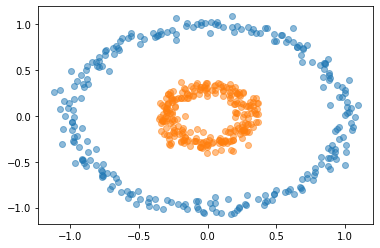

In [20]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=500, factor=0.3, noise=0.05, random_state=0)
for i in range(2):
    plt.scatter(X[y==i,0], X[y==i,1], cmap=plt.cm.get_cmap('RdBu'), alpha=0.5)

If we could just pull the small circle out of the screen ...

<div>
    <img src="come_with_me.jpg" width="500"/>
</div>

We do lift using a polynomial kernel $\phi(x_1, x_2) = [x_1^2, x_2^2, \sqrt{2}x_1 x_2]$ instead of a barbell:

In [21]:
def poly_transformation(X):
    last = np.sqrt(2)*X[:,0]*X[:,1]
    return np.c_[ X*X, last]
X3d = poly_transformation(X)

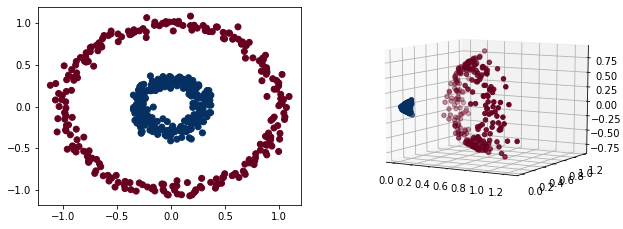

In [22]:
fig = plt.figure(figsize=(16, 8))

ax = fig.add_subplot(231)
ax.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu')

ax = fig.add_subplot(232, projection="3d")
ax.scatter(X3d[:, 0], X3d[:, 1], X3d[:, 2], c=y,  cmap='RdBu')
ax.view_init(10, -60)

credits: I got the _lifting_ name [here](#https://gregorygundersen.com/blog/2019/12/10/kernel-trick/)

As we remember from the KPCA slides, direct projection on the higher dimension space is computationally costly. If the original data is $\mathbb{R}^{n\times d}$ and the kernel space is in $\mathbb{R}^{n\times k}$ with $k\gt d$ we need $nk$ computations to do the transformation. 

However with the _Kernel trick_ we can calculate:
$$ \mathbf{K}(\vec{x}_i,\vec{x}_j) = \mathbf{k}(\vec{x}_i)\mathbf{k}(\vec{x}_j)^T $$
where $\vec{x}_i \in \mathbb{R}^d$, $\mathbf{k}(x_i)\in \mathbb{R}^k$, $k>d$

The kernel trick rests on [Mercer's theorem](#https://en.wikipedia.org/wiki/Mercer%27s_theorem): A symmetric function $k(\mathbf{x}, \mathbf{y})$ can be expressed as an inner product  

$$ k(\mathbf{x}, \mathbf{y}) = \langle \varphi(\mathbf{x}), \varphi(\mathbf{y}) \rangle $$

for some $\varphi(\cdot)$ if and only if $k(\mathbf{x}, \mathbf{y})k(x,y)$ is positive semidefinite, i.e.  

$$\int k(\mathbf{x}, \mathbf{y}) g(\mathbf{x}) g(\mathbf{y}) \text{d}\mathbf{x}\text{d}\mathbf{y} \geq 0, \qquad \forall g $$

### Exploit the Kernel trick in SVM

Let's try to classify the donut data set.

In [23]:
y = np.where(y <= 0, -1, 1)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.1, shuffle=True, random_state=1)
mySVM = SVM()
mySVM.fit(X_train, y_train)
predictions = mySVM.predict(X_test)
print(accuracy(y_test, predictions))

------ Step 49 -> Cost = 0.9977270477503917 -----
------ Step 99 -> Cost = 0.9956320358516463 -----
------ Step 149 -> Cost = 0.9936507852277979 -----
------ Step 199 -> Cost = 0.9924606233901185 -----
------ Step 249 -> Cost = 0.9920421649528821 -----
------ Step 299 -> Cost = 0.9917025321286146 -----
------ Step 349 -> Cost = 0.9914333286876915 -----
------ Step 399 -> Cost = 0.9912314490390411 -----
------ Step 449 -> Cost = 0.9911929513417235 -----
------ Step 499 -> Cost = 0.9911799999530367 -----
0.46


Now on the transformed data (__X3d__)

In [24]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X3d, y, test_size=0.1, shuffle=True, random_state=1)
mySVM = SVM()
mySVM.fit(X_train, y_train)
predictions = mySVM.predict(X_test)
print(accuracy(y_test, predictions))

------ Step 49 -> Cost = 0.07893732207009563 -----
------ Step 99 -> Cost = 0.07759527274028952 -----
------ Step 149 -> Cost = 0.07759391765399624 -----
------ Step 199 -> Cost = 0.0775942151546618 -----
------ Step 249 -> Cost = 0.07759870255225076 -----
------ Step 299 -> Cost = 0.07760007039374377 -----
------ Step 349 -> Cost = 0.0776043832017395 -----
------ Step 399 -> Cost = 0.07760723962582507 -----
------ Step 449 -> Cost = 0.0776074291990573 -----
------ Step 499 -> Cost = 0.07760810218044503 -----
1.0


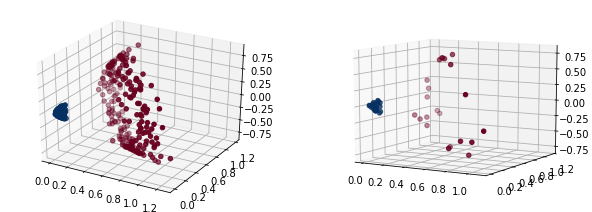

In [25]:
fig = plt.figure(figsize=(16, 8))

ax = fig.add_subplot(231, projection="3d")
ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=y_train, cmap='RdBu')

ax = fig.add_subplot(232, projection="3d")
ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=predictions,  cmap='RdBu')
ax.view_init(10, -60)

To fully exploit the kernel trick we have to reformulate the SVM optimization goal.

<a id="dual"></a>

## Dual SVM problem

### A recap on how to impose constraints

A constrained convex optimization problem can be generally solved with [Lagrange multipliers](#https://mathworld.wolfram.com/LagrangeMultiplier.html):

$$\begin{cases}
    \nabla f(x) = & c \nabla g(x) \\
     g(x) = & 0 
\end{cases}$$

or we simply minimize:
$$ L(x,c) = f(x) - c g(x) $$

for multiple constraints:
$$ \begin{align}
    L(x,c) = & f(x) - \sum_j c_j g_j(x) \\
    \nabla L(x,c) = 0
\end{align}$$

That's for equality constraints. For inequalities:
$$\begin{cases}
g(x) \geq 0 & \rightarrow c \geq 0 \\
g(x) \leq 0 & \rightarrow c \leq 0 \\
g(x) = 0    & c\ \text{unconstrained}
\end{cases}$$

Rewrite the SVM problem:
$$\begin{align}
\text{minimize}\  & \frac{\lambda}{2}\mid\mid \mathbf{w}\mid\mid^2 \\
\text{subject to}\ & y_j(\mathbf{w}\cdot\mathbf{x}_j-)-1 \geq 0 
\end{align}$$

Hence we have one objective $f$ and $m$ inequality constraints $g_i$

Let's write the Lagrangian SVM:
$$ L(\mathbf{w},b,c) = \frac{1}{2}\mid\mid\mathbf{w}\mid\mid^2 - \sum_{i=1}^m c_j[y_j(\mathbf{w\cdot x}_j-b)-1] $$

We want to:
$$\begin{align}
\text{min}\ (\mathbf{w},b)\ \text{max}\ c\  & L(\mathbf{w},b,c) \\
\text{subject to}\ & c_j \geq 0 
\end{align}$$

The gradients will be:
$$\begin{align}
    \frac{\partial L}{\partial \mathbf{w}_i} = &  \mathbf{w}_i - \sum _j c_j y_j x_{ij} = 0\\
    \frac{\partial L}{\partial b} = & - \sum_j c_j y_j = 0
\end{align}$$

Hence $ \mathbf{w} = \sum_j c_j y_j \mathbf{x}_i $

Putting it in the $L$ definition we obtain:
$$\begin{align}
L = & \frac{1}{2} (\sum_{j=1}^m c_j y_j\mathbf{x}_j )\cdot(\sum_{k=1}^m c_k y_k\mathbf{x}_k)-\sum_{j=1}^m c_j[y_j((\sum_{jk1}^m c_k y_k\mathbf{x}_k)\cdot \mathbf{x}_k-b)-1] \\
   = & \frac{1}{2}\sum_{jk} c_j c_k y_j y_k \mathbf{x}_j\cdot\mathbf{x}_k - \sum_{jk} c_j c_k y_j y_k \mathbf{x}_i\cdot\mathbf{x}_j -b \sum_ic_i y_i +\sum_ic_i \\
   = & \sum_j c_j - \frac{1}{2}\sum_{jk} c_j c_k y_j y_k \mathbf{x}_j\cdot\mathbf{x}_k
\end{align}$$

since we know the $b$ term sums to 0

The new problem is:
$$\begin{align}
\text{min}\ c & \frac{1}{2}\sum_{jk} c_j c_k y_j y_k \mathbf{x}_j\cdot\mathbf{x}_k - \sum_j c_j \\
\text{subject to}\ & c_j\geq 0 \forall\ j \\
 & \sum_j c_j y_j = 0
\end{align}$$

which is now exploitable for the Kernel trick. It can be demonstrated that $L$ is concave hence the change of sign.

#### Karush-Kuhn-Tucker Conditions
The [KKT](#https://en.wikipedia.org/wiki/Karush%E2%80%93Kuhn%E2%80%93Tucker_conditions) conditions are necessary to apply the Lagrange multiplier method to inequality constraints. We will not delve deeper about them.

SciKit Learn has a support vector classfier that supports kernels. remember that we can use the `help`:

In [26]:
from sklearn.svm import SVC
help(SVC)

Help on class SVC in module sklearn.svm._classes:

class SVC(sklearn.svm._base.BaseSVC)
 |  SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)
 |  
 |  C-Support Vector Classification.
 |  
 |  The implementation is based on libsvm. The fit time scales at least
 |  quadratically with the number of samples and may be impractical
 |  beyond tens of thousands of samples. For large datasets
 |  consider using :class:`sklearn.svm.LinearSVC` or
 |  :class:`sklearn.linear_model.SGDClassifier` instead, possibly after a
 |  :class:`sklearn.kernel_approximation.Nystroem` transformer.
 |  
 |  The multiclass support is handled according to a one-vs-one scheme.
 |  
 |  For details on the precise mathematical formulation of the provided
 |  kernel functions and how `gamma`, `coef0` and `degree` affect each
 |  

In [27]:
mySVM = SVC(kernel='poly', degree=3)
mySVM.fit(X_train, y_train)

SVC(kernel='poly')

In [28]:
predictions = mySVM.predict(X_test)
print(accuracy(y_test, predictions))

1.0


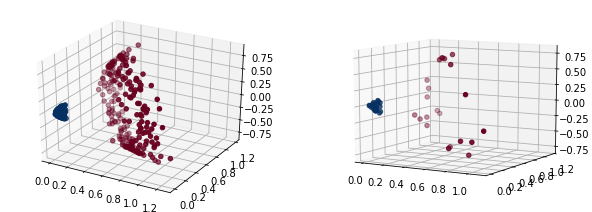

In [29]:
fig = plt.figure(figsize=(16, 8))

ax = fig.add_subplot(231, projection="3d")
ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=y_train, cmap='RdBu')

ax = fig.add_subplot(232, projection="3d")
ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=predictions,  cmap='RdBu')
ax.view_init(10, -60)

Let's check the iris data set

In [30]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target
print(set(y))

{0, 1, 2}


In [31]:
X_train,X_test, y_train, y_test=model_selection.train_test_split(X,y,test_size=0.30)

In [32]:
mySVM = SVC(kernel='rbf')
mySVM.fit(X_train, y_train)
predictions = mySVM.predict(X_test)

In [33]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,predictions))

[[19  0  0]
 [ 0 12  2]
 [ 0  0 12]]


<a id="svr"></a>

## Support vector regression

The formalism used until now can be "reversed" to be used in a regression problem: we set up the hyperplanes in orded to _include_ the points under a given threshold and use the middle hyperplane as a regression result.

<div>
    <img src="svr.png" width="500"/>
</div>